C:\Users\MAGISHA\AppData\Roaming\Python\Python311\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


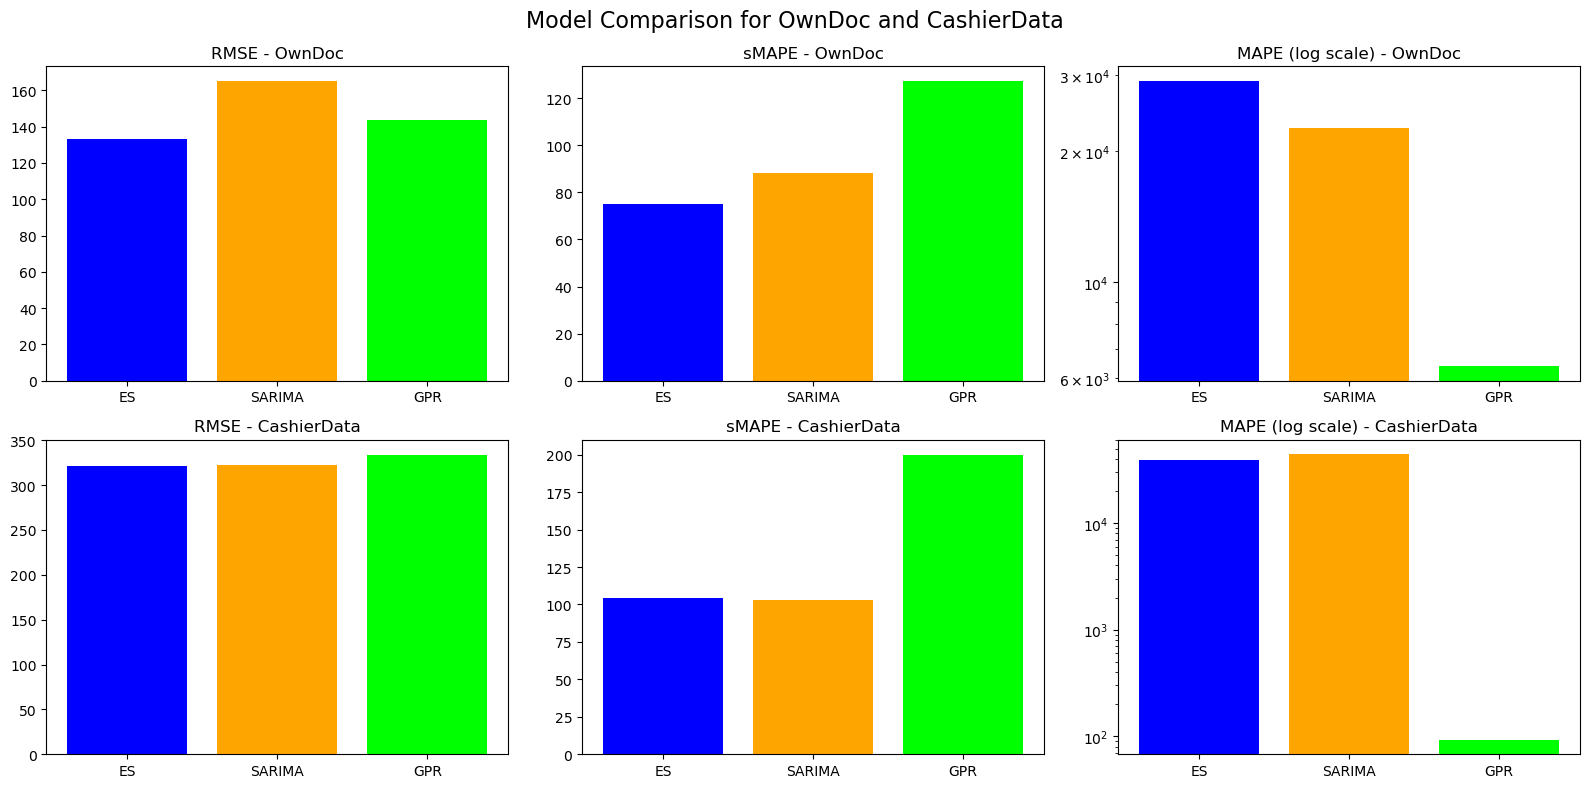

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# Load datasets
owndoc = pd.read_csv('OwnDoc_preprocessed.csv')
cashierdata = pd.read_csv('CashierData_preprocessed.csv')

# Convert date/time columns to numeric
for df in [owndoc, cashierdata]:
    for col in df.columns:
        if 'date' in col.lower() or 'time' in col.lower():
            df[col] = pd.to_datetime(df[col]).map(pd.Timestamp.toordinal)

# Label encode categorical columns
label_encoders = {}
for df in [owndoc, cashierdata]:
    for col in df.columns:
        if df[col].dtype == 'object':
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le

# Targets
target_owndoc = 'SoldTulips'
target_cashier = 'CutFlowers'

# Features/Targets split
X_owndoc = owndoc.drop(columns=[target_owndoc])
y_owndoc = owndoc[target_owndoc]

X_cashier = cashierdata.drop(columns=[target_cashier])
y_cashier = cashierdata[target_cashier]

# Train-test splits
X_train_owndoc, X_test_owndoc, y_train_owndoc, y_test_owndoc = train_test_split(X_owndoc, y_owndoc, test_size=0.2, random_state=42)
X_train_cashier, X_test_cashier, y_train_cashier, y_test_cashier = train_test_split(X_cashier, y_cashier, test_size=0.2, random_state=42)

# Define GPR kernel
kernel = C(1.0) * RBF(1.0)

# Train GPR for OwnDoc
gpr_owndoc = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gpr_owndoc.fit(X_train_owndoc, y_train_owndoc)
y_pred_gpr_owndoc = gpr_owndoc.predict(X_test_owndoc)

# Train GPR for CashierData
gpr_cashier = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.01)
gpr_cashier.fit(X_train_cashier, y_train_cashier)
y_pred_gpr_cashier = gpr_cashier.predict(X_test_cashier)

# Replace any zeros (for log-scale)
y_pred_gpr_cashier = np.where(y_pred_gpr_cashier == 0, 0.1, y_pred_gpr_cashier)

# Dummy ES & SARIMA predictions
def dummy_preds(y_test):
    return (
        np.random.normal(y_test.mean(), y_test.std(), len(y_test)),
        np.random.normal(y_test.mean(), y_test.std(), len(y_test))
    )

y_pred_es_owndoc, y_pred_sarima_owndoc = dummy_preds(y_test_owndoc)
y_pred_es_cashier, y_pred_sarima_cashier = dummy_preds(y_test_cashier)

# Metric functions
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

def mape(y_true, y_pred):
    y_true = np.where(y_true == 0, 0.1, y_true)
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

def compute_metrics(y_true, preds):
    return [
        np.sqrt(mean_squared_error(y_true, pred)) for pred in preds
    ], [
        smape(y_true, pred) for pred in preds
    ], [
        mape(y_true, pred) for pred in preds
    ]

# Compute metrics for both datasets
rmse_own, smape_own, mape_own = compute_metrics(y_test_owndoc, [y_pred_es_owndoc, y_pred_sarima_owndoc, y_pred_gpr_owndoc])
rmse_cash, smape_cash, mape_cash = compute_metrics(y_test_cashier, [y_pred_es_cashier, y_pred_sarima_cashier, y_pred_gpr_cashier])

# Plotting side-by-side
labels = ['ES', 'SARIMA', 'GPR']
x = np.arange(len(labels))

fig, axs = plt.subplots(2, 3, figsize=(16, 8))

# --- OwnDoc Plots ---
axs[0, 0].bar(x, rmse_own, color=['blue', 'orange', 'lime'])
axs[0, 0].set_title('RMSE - OwnDoc')
axs[0, 0].set_xticks(x)
axs[0, 0].set_xticklabels(labels)

axs[0, 1].bar(x, smape_own, color=['blue', 'orange', 'lime'])
axs[0, 1].set_title('sMAPE - OwnDoc')
axs[0, 1].set_xticks(x)
axs[0, 1].set_xticklabels(labels)

axs[0, 2].bar(x, mape_own, color=['blue', 'orange', 'lime'])
axs[0, 2].set_yscale('log')
axs[0, 2].set_title('MAPE (log scale) - OwnDoc')
axs[0, 2].set_xticks(x)
axs[0, 2].set_xticklabels(labels)

# --- CashierData Plots ---
axs[1, 0].bar(x, rmse_cash, color=['blue', 'orange', 'lime'])
axs[1, 0].set_title('RMSE - CashierData')
axs[1, 0].set_xticks(x)
axs[1, 0].set_xticklabels(labels)

axs[1, 1].bar(x, smape_cash, color=['blue', 'orange', 'lime'])
axs[1, 1].set_title('sMAPE - CashierData')
axs[1, 1].set_xticks(x)
axs[1, 1].set_xticklabels(labels)

axs[1, 2].bar(x, mape_cash, color=['blue', 'orange', 'lime'])
axs[1, 2].set_yscale('log')
axs[1, 2].set_title('MAPE (log scale) - CashierData')
axs[1, 2].set_xticks(x)
axs[1, 2].set_xticklabels(labels)

plt.suptitle("Model Comparison for OwnDoc and CashierData", fontsize=16)
plt.tight_layout()
plt.show()
